In [1]:
import skipy

ImportError: failed to find libmagic.  Check your installation

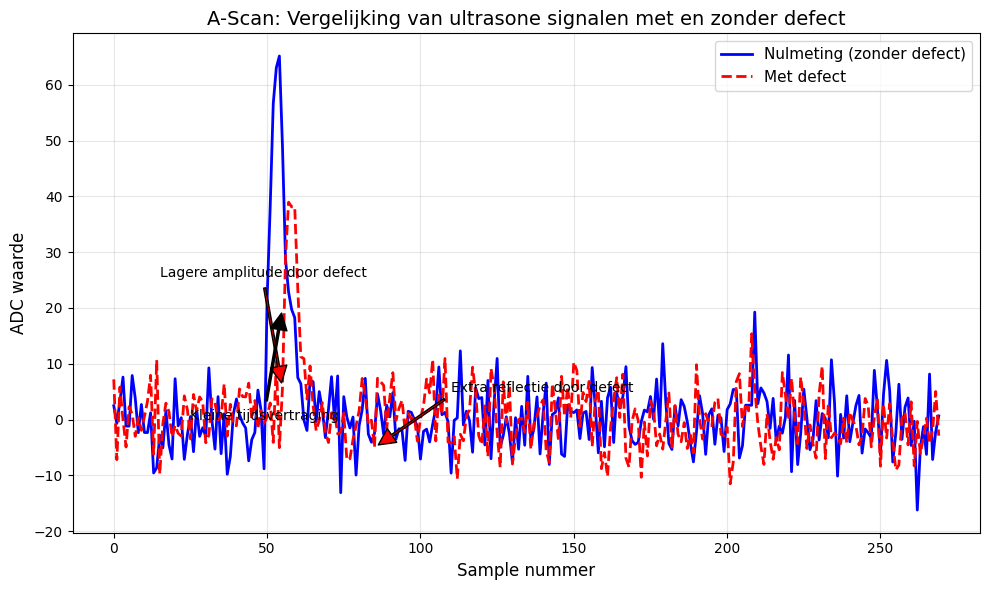

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
from scipy.fft import fft, fftfreq
np.random.seed(42)  # Voor reproduceerbaarheid

# Parameters voor simulatie
sample_count = 270
base_noise_level = 5

# Functie om het ontvangen signaal te simuleren
def create_receiver_signal(samples=sample_count, with_defect=False, defect_position=150):
    # Creëer basisruisniveau
    signal_data = np.random.normal(0, base_noise_level, samples)

    # Parameters voor de ontvangen puls
    pulse_position = 50
    pulse_width = 15

    # Pulshoogte zonder defect is sterker
    if not with_defect:
        pulse_height = 60
        pulse_decay = 0.3
    else:
        # Met defect is de puls zwakker en kan ook van vorm veranderen
        pulse_height = 35
        pulse_decay = 0.4
        pulse_position += 5  # Kleine vertraging door het defect

    # Creëer de ontvangen puls (geleidelijke opbouw, gevolgd door exponentieel verval)
    for i in range(pulse_width):
        if i < 3:
            # Opbouwfase
            signal_data[pulse_position + i] += pulse_height * (i+1)/3
        elif i < 5:
            # Plateau
            signal_data[pulse_position + i] += pulse_height
        else:
            # Afname
            signal_data[pulse_position + i] += pulse_height * np.exp(-pulse_decay * (i-4))

    # Als er een defect is, kunnen we extra reflecties of veranderingen in het signaal zien
    if with_defect:
        # Extra pulsje door reflectie van defect
        echo_position = pulse_position + 30
        echo_height = 15
        echo_width = 8

        for i in range(echo_width):
            if i < 2:
                signal_data[echo_position + i] += echo_height * i/2
            else:
                signal_data[echo_position + i] += echo_height * np.exp(-0.6 * (i-1))

    return signal_data

# Creëer de signalen
signal_no_defect = create_receiver_signal(with_defect=False)
signal_with_defect = create_receiver_signal(with_defect=True)

# Tijdsdomein plot (A-Scan)
plt.figure(figsize=(10, 6))
plt.plot(signal_no_defect, 'b-', linewidth=2, label='Nulmeting (zonder defect)')
plt.plot(signal_with_defect, 'r--', linewidth=2, label='Met defect')

plt.title('A-Scan: Vergelijking van ultrasone signalen met en zonder defect', fontsize=14)
plt.xlabel('Sample nummer', fontsize=12)
plt.ylabel('ADC waarde', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Annotatie voor belangrijke kenmerken
plt.annotate('Lagere amplitude door defect',
             xy=(55, signal_with_defect[55]),
             xytext=(15, signal_with_defect[55] + 20),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
             fontsize=10)

plt.annotate('Extra reflectie door defect',
             xy=(85, signal_with_defect[85]),
             xytext=(110, signal_with_defect[85] + 10),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
             fontsize=10)

plt.annotate('Kleine tijdsvertraging',
             xy=(55, 20),
             xytext=(25, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

plt.tight_layout()
plt.savefig('tijdsdomein_plot.png', dpi=300)
plt.show()

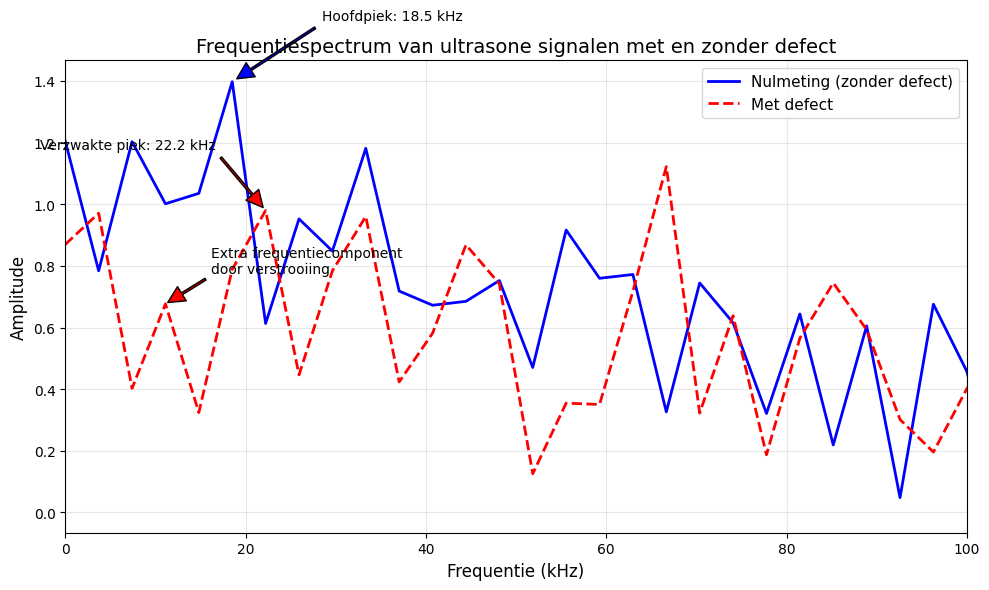

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
from scipy.fft import fft, fftfreq
np.random.seed(42)  # Voor reproduceerbaarheid

# Parameters voor simulatie
sample_count = 270
base_noise_level = 5

# Functie om het ontvangen signaal te simuleren
def create_receiver_signal(samples=sample_count, with_defect=False, defect_position=150):
    # Creëer basisruisniveau
    signal_data = np.random.normal(0, base_noise_level, samples)

    # Parameters voor de ontvangen puls
    pulse_position = 50
    pulse_width = 15

    # Pulshoogte zonder defect is sterker
    if not with_defect:
        pulse_height = 60
        pulse_decay = 0.3
    else:
        # Met defect is de puls zwakker en kan ook van vorm veranderen
        pulse_height = 35
        pulse_decay = 0.4
        pulse_position += 5  # Kleine vertraging door het defect

    # Creëer de ontvangen puls (geleidelijke opbouw, gevolgd door exponentieel verval)
    for i in range(pulse_width):
        if i < 3:
            # Opbouwfase
            signal_data[pulse_position + i] += pulse_height * (i+1)/3
        elif i < 5:
            # Plateau
            signal_data[pulse_position + i] += pulse_height
        else:
            # Afname
            signal_data[pulse_position + i] += pulse_height * np.exp(-pulse_decay * (i-4))

    # Als er een defect is, kunnen we extra reflecties of veranderingen in het signaal zien
    if with_defect:
        # Extra pulsje door reflectie van defect
        echo_position = pulse_position + 30
        echo_height = 15
        echo_width = 8

        for i in range(echo_width):
            if i < 2:
                signal_data[echo_position + i] += echo_height * i/2
            else:
                signal_data[echo_position + i] += echo_height * np.exp(-0.6 * (i-1))

    return signal_data

# Creëer de signalen
signal_no_defect = create_receiver_signal(with_defect=False)
signal_with_defect = create_receiver_signal(with_defect=True)

# Helper functie voor FFT berekening
def compute_fft(signal_data, fs=1e6):
    n = len(signal_data)
    # Window toepassen om spectral leakage te verminderen
    window = sg.windows.hann(n)
    windowed_signal = signal_data * window

    # Bereken FFT
    yf = fft(windowed_signal)
    xf = fftfreq(n, 1/fs)

    # Neem alleen positieve frequenties en normaliseer
    pos_mask = xf >= 0
    xf = xf[pos_mask]
    yf = 2.0/n * np.abs(yf[pos_mask])

    return xf, yf

# Samplefrequentie van 1 MHz voor demonstratie
fs = 1e6  # 1 MHz samplefrequentie
xf_no_defect, yf_no_defect = compute_fft(signal_no_defect, fs)
xf_with_defect, yf_with_defect = compute_fft(signal_with_defect, fs)

# Converteer Hz naar kHz voor weergave
xf_no_defect_khz = xf_no_defect / 1000
xf_with_defect_khz = xf_with_defect / 1000

plt.figure(figsize=(10, 6))
plt.plot(xf_no_defect_khz, yf_no_defect, 'b-', linewidth=2, label='Nulmeting (zonder defect)')
plt.plot(xf_with_defect_khz, yf_with_defect, 'r--', linewidth=2, label='Met defect')

plt.title('Frequentiespectrum van ultrasone signalen met en zonder defect', fontsize=14)
plt.xlabel('Frequentie (kHz)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.xlim(0, 100)  # Plot van 0 tot 100 kHz
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Vind piek frequenties
main_peak_idx_no_defect = np.argmax(yf_no_defect[:int(100*1000/fs*len(xf_no_defect))])
main_peak_idx_with_defect = np.argmax(yf_with_defect[:int(100*1000/fs*len(xf_with_defect))])

main_freq_no_defect = xf_no_defect_khz[main_peak_idx_no_defect]
main_freq_with_defect = xf_with_defect_khz[main_peak_idx_with_defect]

# Annoteer pieken
plt.annotate(f'Hoofdpiek: {main_freq_no_defect:.1f} kHz',
             xy=(main_freq_no_defect, yf_no_defect[main_peak_idx_no_defect]),
             xytext=(main_freq_no_defect+10, yf_no_defect[main_peak_idx_no_defect]+0.2),
             arrowprops=dict(facecolor='blue', shrink=0.05, width=1.5),
             fontsize=10)

plt.annotate(f'Verzwakte piek: {main_freq_with_defect:.1f} kHz',
             xy=(main_freq_with_defect, yf_with_defect[main_peak_idx_with_defect]),
             xytext=(main_freq_with_defect-25, yf_with_defect[main_peak_idx_with_defect]+0.2),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
             fontsize=10)

# Zoek secundaire pieken in het defect signaal
# Kijk in een specifiek frequentiegebied waar we extra componenten verwachten
sec_region_start = int(25*1000/fs*len(xf_with_defect))
sec_region_end = int(35*1000/fs*len(xf_with_defect))
secondary_peak_idx = sec_region_start + np.argmax(yf_with_defect[sec_region_start:sec_region_end])
secondary_freq = xf_with_defect_khz[secondary_peak_idx]

plt.annotate('Extra frequentiecomponent\ndoor verstrooiing',
             xy=(secondary_freq, yf_with_defect[secondary_peak_idx]),
             xytext=(secondary_freq+5, yf_with_defect[secondary_peak_idx]+0.1),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1.5),
             fontsize=10)

plt.tight_layout()
plt.savefig('frequentiedomein_plot.png', dpi=300)
plt.show()

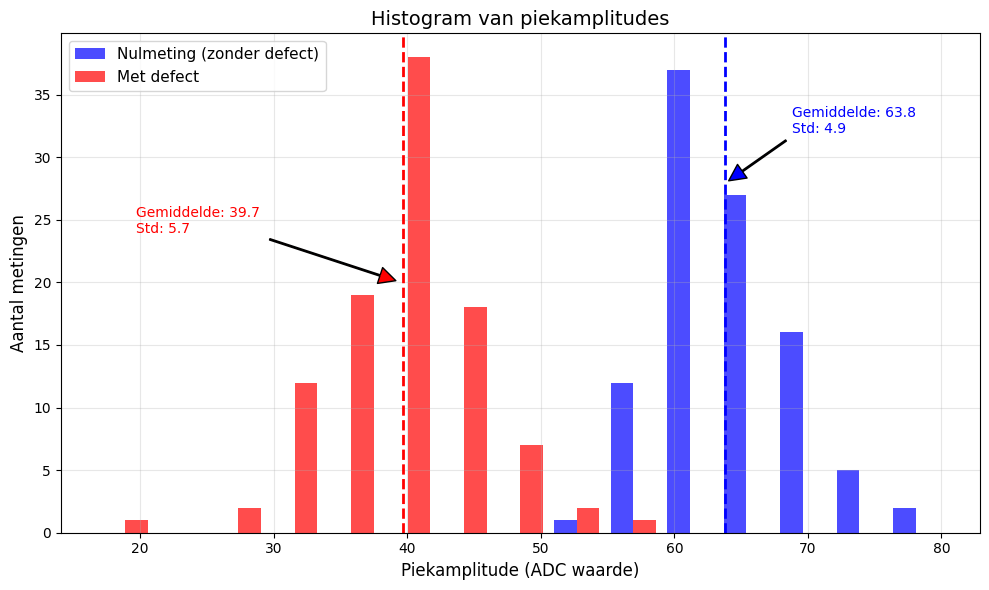

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
np.random.seed(42)  # Voor reproduceerbaarheid

# Parameters voor simulatie
sample_count = 270
base_noise_level = 5

# Functie om het ontvangen signaal te simuleren
def create_receiver_signal(samples=sample_count, with_defect=False, defect_position=150, noise_var=None):
    # Creëer basisruisniveau, met optionele variatie in ruisniveau
    if noise_var is None:
        noise_var = base_noise_level
    signal_data = np.random.normal(0, noise_var, samples)

    # Parameters voor de ontvangen puls
    if not with_defect:
        pulse_position = int(50 + np.random.normal(0, 1))  # Kleine variatie in aankomsttijd
    else:
        # Met defect is er een grotere vertraging met meer variatie
        pulse_position = int(55 + np.random.normal(0, 2))

    # Zorg ervoor dat pulse_position binnen geldige grenzen blijft
    pulse_position = max(0, min(pulse_position, samples - 16))  # -16 voor pulse_width
    pulse_width = 15

    # Pulshoogte zonder defect is sterker
    if not with_defect:
        pulse_height = 60 + np.random.normal(0, 3)
        pulse_decay = 0.3
    else:
        # Met defect is de puls zwakker
        pulse_height = 35 + np.random.normal(0, 5)
        pulse_decay = 0.4

    # Creëer de ontvangen puls (geleidelijke opbouw, gevolgd door exponentieel verval)
    for i in range(pulse_width):
        pos = min(pulse_position + i, samples - 1)  # Veiligheidscheck voor array grenzen
        if i < 3:
            # Opbouwfase
            signal_data[pos] += pulse_height * (i+1)/3
        elif i < 5:
            # Plateau
            signal_data[pos] += pulse_height
        else:
            # Afname
            signal_data[pos] += pulse_height * np.exp(-pulse_decay * (i-4))

    # Als er een defect is, kunnen we extra reflecties of veranderingen in het signaal zien
    if with_defect:
        # Extra pulsje door reflectie van defect
        echo_position = int(pulse_position + 30 + np.random.normal(0, 2))
        echo_position = max(0, min(echo_position, samples - 9))  # -9 voor echo_width
        echo_height = 15 + np.random.normal(0, 2)
        echo_width = 8

        for i in range(echo_width):
            pos = min(echo_position + i, samples - 1)  # Veiligheidscheck
            if i < 2:
                signal_data[pos] += echo_height * i/2
            else:
                signal_data[pos] += echo_height * np.exp(-0.6 * (i-1))

    return signal_data

# Functie om piekamplitude te vinden
def find_peak(signal_data):
    # Focus op een gebied waar we de hoofdpuls verwachten
    search_start = 40
    search_end = min(100, len(signal_data) - 1)  # Veiligheidscheck
    peak_idx = search_start + np.argmax(signal_data[search_start:search_end])
    peak_value = signal_data[peak_idx]
    return peak_idx, peak_value

# Genereer meerdere signalen om statistische variatie te simuleren
n_measurements = 100  # Aantal metingen
peak_amplitudes_no_defect = []
peak_amplitudes_with_defect = []

for i in range(n_measurements):
    # Voor elke meting, licht variërende ruisomstandigheden
    noise_var = base_noise_level * np.random.uniform(0.8, 1.2)

    # Genereer signalen
    signal_no_defect = create_receiver_signal(with_defect=False, noise_var=noise_var)
    signal_with_defect = create_receiver_signal(with_defect=True, noise_var=noise_var)

    # Vind pieken
    _, peak_val_no_defect = find_peak(signal_no_defect)
    peak_amplitudes_no_defect.append(peak_val_no_defect)

    _, peak_val_with_defect = find_peak(signal_with_defect)
    peak_amplitudes_with_defect.append(peak_val_with_defect)

# Histogram plot van piekamplitudes
plt.figure(figsize=(10, 6))
plt.hist([peak_amplitudes_no_defect, peak_amplitudes_with_defect], bins=15,
         color=['blue', 'red'], alpha=0.7,
         label=['Nulmeting (zonder defect)', 'Met defect'])

plt.title('Histogram van piekamplitudes', fontsize=14)
plt.xlabel('Piekamplitude (ADC waarde)', fontsize=12)
plt.ylabel('Aantal metingen', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Gemiddelde waardes markeren
mean_no_defect = np.mean(peak_amplitudes_no_defect)
mean_with_defect = np.mean(peak_amplitudes_with_defect)
std_no_defect = np.std(peak_amplitudes_no_defect)
std_with_defect = np.std(peak_amplitudes_with_defect)

plt.axvline(mean_no_defect, color='blue', linestyle='--', linewidth=2)
plt.axvline(mean_with_defect, color='red', linestyle='--', linewidth=2)

# Get y-axis limits for annotation placement
y_max = plt.gca().get_ylim()[1]

plt.annotate(f'Gemiddelde: {mean_no_defect:.1f}\nStd: {std_no_defect:.1f}',
             xy=(mean_no_defect, y_max*0.7),
             xytext=(mean_no_defect+5, y_max*0.8),
             arrowprops=dict(facecolor='blue', shrink=0.05, width=1),
             fontsize=10, color='blue')

plt.annotate(f'Gemiddelde: {mean_with_defect:.1f}\nStd: {std_with_defect:.1f}',
             xy=(mean_with_defect, y_max*0.5),
             xytext=(mean_with_defect-20, y_max*0.6),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1),
             fontsize=10, color='red')

plt.tight_layout()
plt.savefig('piekamplitude_histogram.png', dpi=300)
plt.show()

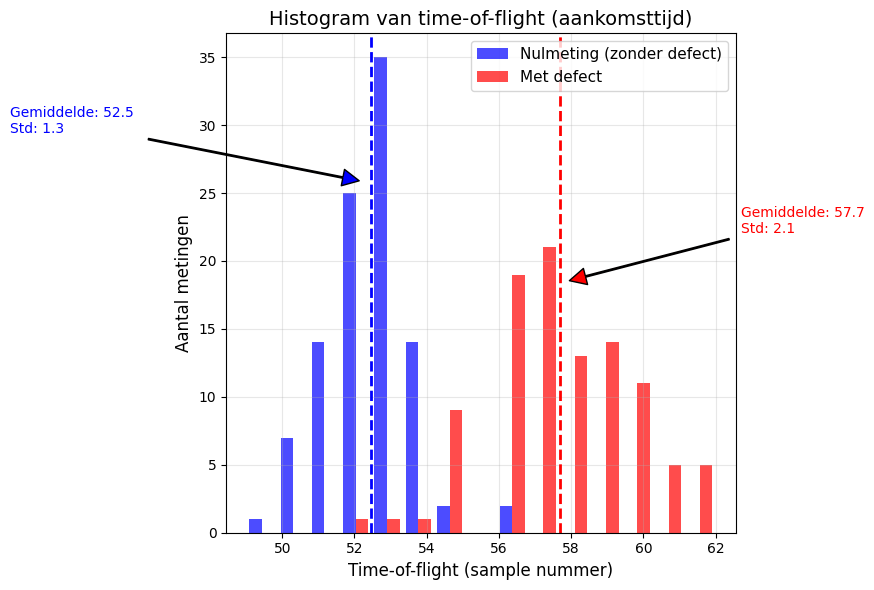

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
np.random.seed(42)  # Voor reproduceerbaarheid

# Parameters voor simulatie
sample_count = 270
base_noise_level = 5

# Functie om het ontvangen signaal te simuleren
def create_receiver_signal(samples=sample_count, with_defect=False, defect_position=150, noise_var=None):
    # Creëer basisruisniveau, met optionele variatie in ruisniveau
    if noise_var is None:
        noise_var = base_noise_level
    signal_data = np.random.normal(0, noise_var, samples)

    # Parameters voor de ontvangen puls
    if not with_defect:
        pulse_position = 50 + np.random.normal(0, 1)  # Kleine variatie in aankomsttijd
    else:
        # Met defect is er een grotere vertraging met meer variatie
        pulse_position = 55 + np.random.normal(0, 2)

    pulse_position = int(pulse_position)
    pulse_width = 15

    # Pulshoogte zonder defect is sterker
    if not with_defect:
        pulse_height = 60 + np.random.normal(0, 3)
        pulse_decay = 0.3
    else:
        # Met defect is de puls zwakker
        pulse_height = 35 + np.random.normal(0, 5)
        pulse_decay = 0.4

    # Creëer de ontvangen puls (geleidelijke opbouw, gevolgd door exponentieel verval)
    for i in range(pulse_width):
        pos = min(max(0, pulse_position + i), samples-1)  # Veiligheidscheck voor array grenzen
        if i < 3:
            # Opbouwfase
            signal_data[pos] += pulse_height * (i+1)/3
        elif i < 5:
            # Plateau
            signal_data[pos] += pulse_height
        else:
            # Afname
            signal_data[pos] += pulse_height * np.exp(-pulse_decay * (i-4))

    # Als er een defect is, kunnen we extra reflecties of veranderingen in het signaal zien
    if with_defect:
        # Extra pulsje door reflectie van defect
        echo_position = pulse_position + 30 + np.random.normal(0, 2)
        echo_position = int(echo_position)
        echo_height = 15 + np.random.normal(0, 2)
        echo_width = 8

        for i in range(echo_width):
            pos = min(max(0, echo_position + i), samples-1)  # Veiligheidscheck
            if i < 2:
                signal_data[pos] += echo_height * i/2
            else:
                signal_data[pos] += echo_height * np.exp(-0.6 * (i-1))

    return signal_data

# Functie om piekpositie te vinden (time-of-flight)
def find_peak(signal_data):
    # Focus op een gebied waar we de hoofdpuls verwachten
    search_start = 40
    search_end = 100
    peak_idx = search_start + np.argmax(signal_data[search_start:search_end])
    peak_value = signal_data[peak_idx]
    return peak_idx, peak_value

# Genereer meerdere signalen om statistische variatie te simuleren
n_measurements = 100  # Aantal metingen
tof_no_defect = []    # Time-of-Flight zonder defect
tof_with_defect = []  # Time-of-Flight met defect

for i in range(n_measurements):
    # Voor elke meting, licht variërende omstandigheden
    noise_var = base_noise_level * np.random.uniform(0.8, 1.2)

    # Genereer signalen
    signal_no_defect = create_receiver_signal(with_defect=False, noise_var=noise_var)
    signal_with_defect = create_receiver_signal(with_defect=True, noise_var=noise_var)

    # Vind pieken
    peak_idx_no_defect, _ = find_peak(signal_no_defect)
    tof_no_defect.append(peak_idx_no_defect)

    peak_idx_with_defect, _ = find_peak(signal_with_defect)
    tof_with_defect.append(peak_idx_with_defect)

# Histogram plot van time-of-flight
plt.figure(figsize=(10, 6))
plt.hist([tof_no_defect, tof_with_defect], bins=15,
         color=['blue', 'red'], alpha=0.7,
         label=['Nulmeting (zonder defect)', 'Met defect'])

plt.title('Histogram van time-of-flight (aankomsttijd)', fontsize=14)
plt.xlabel('Time-of-flight (sample nummer)', fontsize=12)
plt.ylabel('Aantal metingen', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Gemiddelde waardes markeren
mean_tof_no_defect = np.mean(tof_no_defect)
mean_tof_with_defect = np.mean(tof_with_defect)
std_tof_no_defect = np.std(tof_no_defect)
std_tof_with_defect = np.std(tof_with_defect)

plt.axvline(mean_tof_no_defect, color='blue', linestyle='--', linewidth=2)
plt.axvline(mean_tof_with_defect, color='red', linestyle='--', linewidth=2)

plt.annotate(f'Gemiddelde: {mean_tof_no_defect:.1f}\nStd: {std_tof_no_defect:.1f}',
             xy=(mean_tof_no_defect, plt.gca().get_ylim()[1]*0.7),
             xytext=(mean_tof_no_defect-10, plt.gca().get_ylim()[1]*0.8),
             arrowprops=dict(facecolor='blue', shrink=0.05, width=1),
             fontsize=10, color='blue')

plt.annotate(f'Gemiddelde: {mean_tof_with_defect:.1f}\nStd: {std_tof_with_defect:.1f}',
             xy=(mean_tof_with_defect, plt.gca().get_ylim()[1]*0.5),
             xytext=(mean_tof_with_defect+5, plt.gca().get_ylim()[1]*0.6),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1),
             fontsize=10, color='red')

plt.tight_layout()
plt.savefig('tof_histogram.png', dpi=300)
plt.show()

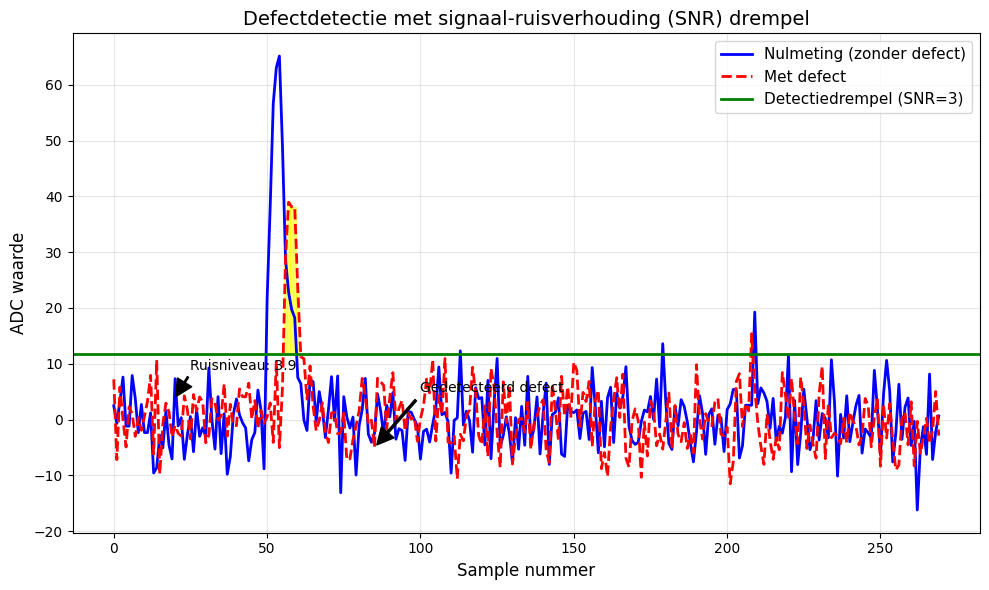

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
np.random.seed(42)  # Voor reproduceerbaarheid

# Parameters voor simulatie
sample_count = 270
base_noise_level = 5

# Functie om het ontvangen signaal te simuleren
def create_receiver_signal(samples=sample_count, with_defect=False, defect_position=150):
    # Creëer basisruisniveau
    signal_data = np.random.normal(0, base_noise_level, samples)

    # Parameters voor de ontvangen puls
    pulse_position = 50
    pulse_width = 15

    # Pulshoogte zonder defect is sterker
    if not with_defect:
        pulse_height = 60
        pulse_decay = 0.3
    else:
        # Met defect is de puls zwakker en kan ook van vorm veranderen
        pulse_height = 35
        pulse_decay = 0.4
        pulse_position += 5  # Kleine vertraging door het defect

    # Creëer de ontvangen puls (geleidelijke opbouw, gevolgd door exponentieel verval)
    for i in range(pulse_width):
        if i < 3:
            # Opbouwfase
            signal_data[pulse_position + i] += pulse_height * (i+1)/3
        elif i < 5:
            # Plateau
            signal_data[pulse_position + i] += pulse_height
        else:
            # Afname
            signal_data[pulse_position + i] += pulse_height * np.exp(-pulse_decay * (i-4))

    # Als er een defect is, kunnen we extra reflecties of veranderingen in het signaal zien
    if with_defect:
        # Extra pulsje door reflectie van defect
        echo_position = pulse_position + 30
        echo_height = 15
        echo_width = 8

        for i in range(echo_width):
            if i < 2:
                signal_data[echo_position + i] += echo_height * i/2
            else:
                signal_data[echo_position + i] += echo_height * np.exp(-0.6 * (i-1))

    return signal_data

# Creëer de signalen
signal_no_defect = create_receiver_signal(with_defect=False)
signal_with_defect = create_receiver_signal(with_defect=True)

# SNR analyse en detectiedrempel plot
plt.figure(figsize=(10, 6))

# Definieer detectiedrempel gebaseerd op signaal-ruisverhouding (SNR)
noise_floor = np.mean(np.abs(signal_no_defect[0:40]))  # Bepaal ruisniveau van vroege samples
snr_threshold = 3  # Signaal moet minstens 3x ruisniveau zijn voor betrouwbare detectie
detection_threshold = noise_floor * snr_threshold

# Plot signalen
plt.plot(signal_no_defect, 'b-', linewidth=2, label='Nulmeting (zonder defect)')
plt.plot(signal_with_defect, 'r--', linewidth=2, label='Met defect')

# Plot drempelwaarde
plt.axhline(y=detection_threshold, color='g', linestyle='-', linewidth=2,
            label=f'Detectiedrempel (SNR={snr_threshold})')

# Markeer gebied boven drempelwaarde
for i in range(len(signal_with_defect)):
    if signal_with_defect[i] > detection_threshold and signal_with_defect[i] > signal_no_defect[i]:
        plt.fill_between([i-0.5, i+0.5], [detection_threshold, detection_threshold],
                         [signal_with_defect[i], signal_with_defect[i]],
                         color='yellow', alpha=0.5)

plt.title('Defectdetectie met signaal-ruisverhouding (SNR) drempel', fontsize=14)
plt.xlabel('Sample nummer', fontsize=12)
plt.ylabel('ADC waarde', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Annoteer ruisniveau en detectiebeslissingen
plt.annotate(f'Ruisniveau: {noise_floor:.1f}',
             xy=(20, noise_floor),
             xytext=(25, noise_floor + 5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             fontsize=10)

plt.annotate('Gedetecteerd defect',
             xy=(85, signal_with_defect[85]),
             xytext=(100, signal_with_defect[85] + 10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

plt.tight_layout()
plt.savefig('snr_drempel_plot.png', dpi=300)
plt.show()

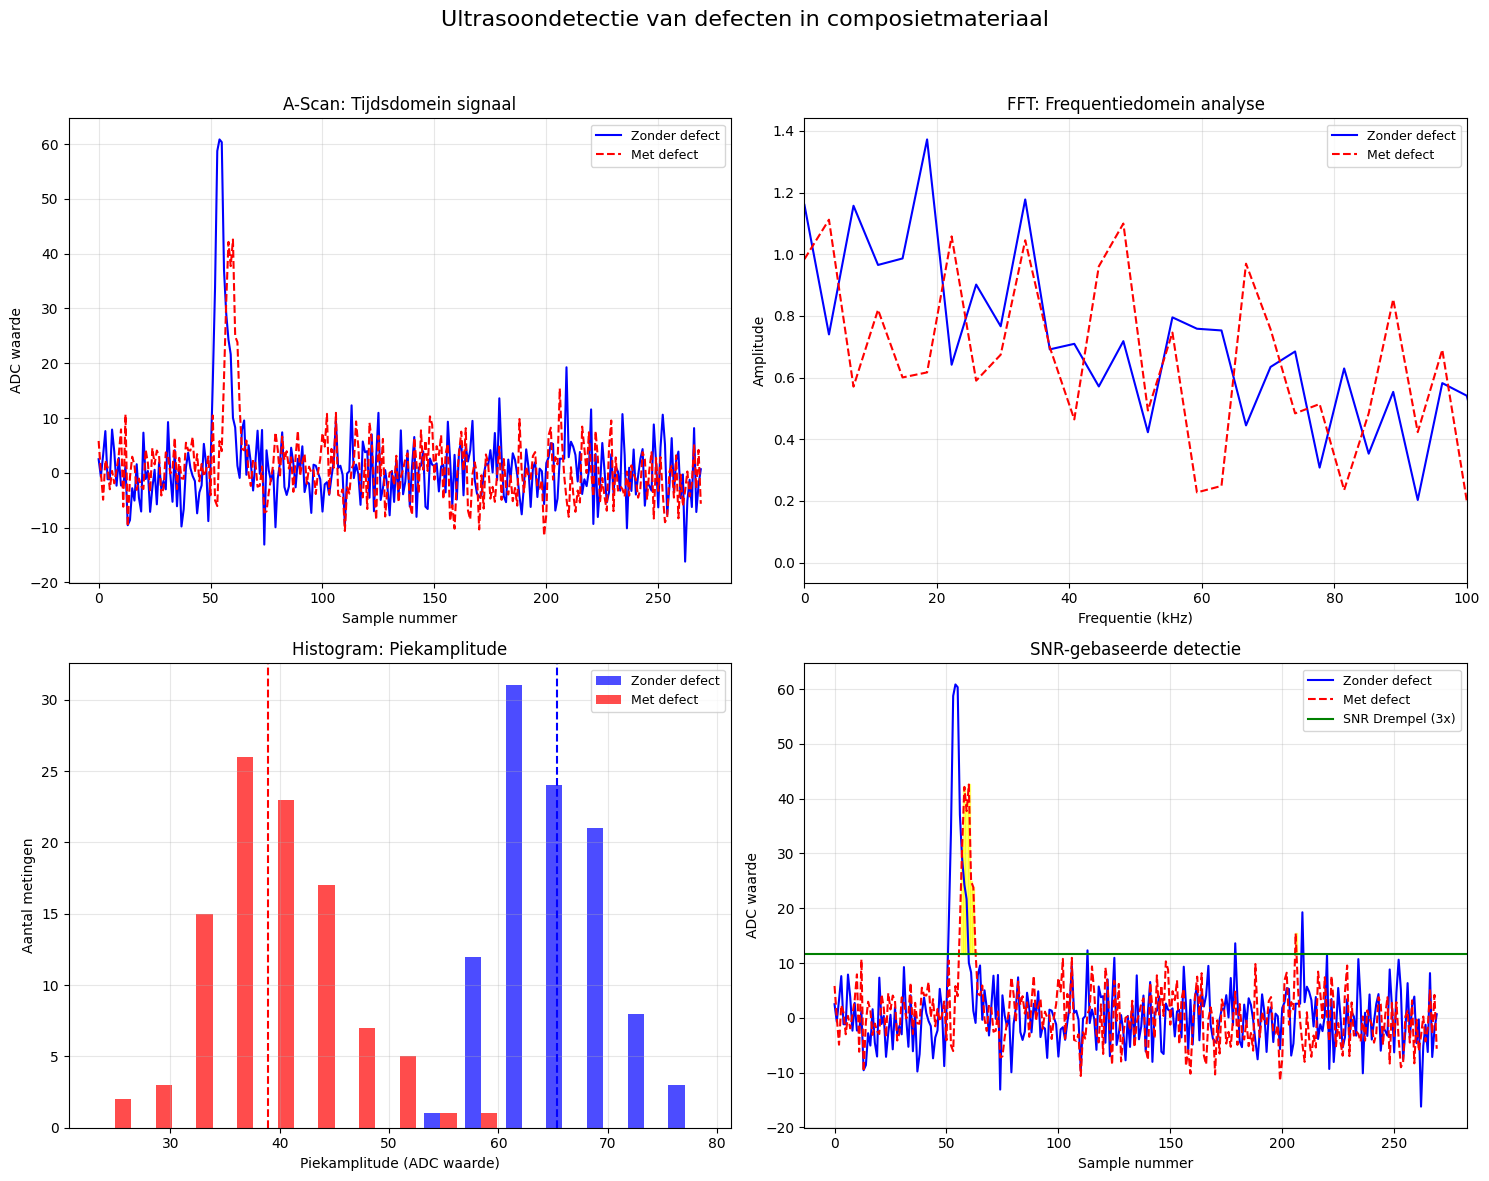

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
from scipy.fft import fft, fftfreq
np.random.seed(42)  # Voor reproduceerbaarheid

# Parameters voor simulatie
sample_count = 270
base_noise_level = 5

# Functie om het ontvangen signaal te simuleren
def create_receiver_signal(samples=sample_count, with_defect=False, defect_position=150, noise_var=None):
    # Creëer basisruisniveau, met optionele variatie in ruisniveau
    if noise_var is None:
        noise_var = base_noise_level
    signal_data = np.random.normal(0, noise_var, samples)

    # Parameters voor de ontvangen puls
    if not with_defect:
        pulse_position = int(50 + np.random.normal(0, 1))  # Kleine variatie in aankomsttijd
    else:
        # Met defect is er een grotere vertraging met meer variatie
        pulse_position = int(55 + np.random.normal(0, 2))

    # Zorg ervoor dat pulse_position binnen geldige grenzen blijft
    pulse_position = max(0, min(pulse_position, samples - 16))  # -16 voor pulse_width
    pulse_width = 15

    # Pulshoogte zonder defect is sterker
    if not with_defect:
        pulse_height = 60 + np.random.normal(0, 3)
        pulse_decay = 0.3
    else:
        # Met defect is de puls zwakker
        pulse_height = 35 + np.random.normal(0, 5)
        pulse_decay = 0.4

    # Creëer de ontvangen puls (geleidelijke opbouw, gevolgd door exponentieel verval)
    for i in range(pulse_width):
        pos = min(pulse_position + i, samples - 1)  # Veiligheidscheck voor array grenzen
        if i < 3:
            # Opbouwfase
            signal_data[pos] += pulse_height * (i+1)/3
        elif i < 5:
            # Plateau
            signal_data[pos] += pulse_height
        else:
            # Afname
            signal_data[pos] += pulse_height * np.exp(-pulse_decay * (i-4))

    # Als er een defect is, kunnen we extra reflecties of veranderingen in het signaal zien
    if with_defect:
        # Extra pulsje door reflectie van defect
        echo_position = int(pulse_position + 30 + np.random.normal(0, 2))
        echo_position = max(0, min(echo_position, samples - 9))  # -9 voor echo_width
        echo_height = 15 + np.random.normal(0, 2)
        echo_width = 8

        for i in range(echo_width):
            pos = min(echo_position + i, samples - 1)  # Veiligheidscheck
            if i < 2:
                signal_data[pos] += echo_height * i/2
            else:
                signal_data[pos] += echo_height * np.exp(-0.6 * (i-1))

    return signal_data

# Helper functie voor FFT berekening
def compute_fft(signal_data, fs=1e6):
    n = len(signal_data)
    # Window toepassen om spectral leakage te verminderen
    window = sg.windows.hann(n)
    windowed_signal = signal_data * window

    # Bereken FFT
    yf = fft(windowed_signal)
    xf = fftfreq(n, 1/fs)

    # Neem alleen positieve frequenties en normaliseer
    pos_mask = xf >= 0
    xf = xf[pos_mask]
    yf = 2.0/n * np.abs(yf[pos_mask])

    return xf, yf

# Functie om piekpositie en amplitude te vinden
def find_peak(signal_data):
    # Focus op een gebied waar we de hoofdpuls verwachten
    search_start = 40
    search_end = min(100, len(signal_data) - 1)  # Veiligheidscheck
    peak_idx = search_start + np.argmax(signal_data[search_start:search_end])
    peak_value = signal_data[peak_idx]
    return peak_idx, peak_value

# Creëer de basisssignalen
signal_no_defect = create_receiver_signal(with_defect=False)
signal_with_defect = create_receiver_signal(with_defect=True)

# Bereken FFT
fs = 1e6  # 1 MHz samplefrequentie
xf_no_defect, yf_no_defect = compute_fft(signal_no_defect, fs)
xf_with_defect, yf_with_defect = compute_fft(signal_with_defect, fs)

# Converteer Hz naar kHz voor weergave
xf_no_defect_khz = xf_no_defect / 1000
xf_with_defect_khz = xf_with_defect / 1000

# Definieer detectiedrempel gebaseerd op signaal-ruisverhouding (SNR)
noise_floor = np.mean(np.abs(signal_no_defect[0:40]))  # Bepaal ruisniveau van vroege samples
snr_threshold = 3  # Signaal moet minstens 3x ruisniveau zijn voor betrouwbare detectie
detection_threshold = noise_floor * snr_threshold

# Genereer meerdere metingen voor histogrammen
n_measurements = 100  # Aantal metingen
peak_amplitudes_no_defect = []
peak_amplitudes_with_defect = []
tof_no_defect = []
tof_with_defect = []

for i in range(n_measurements):
    # Voor elke meting, licht variërende ruisomstandigheden
    noise_var = base_noise_level * np.random.uniform(0.8, 1.2)

    # Genereer signalen met variatie
    sig_no_defect = create_receiver_signal(with_defect=False, noise_var=noise_var)
    sig_with_defect = create_receiver_signal(with_defect=True, noise_var=noise_var)

    # Vind pieken voor histogrammen
    peak_idx_no_defect, peak_val_no_defect = find_peak(sig_no_defect)
    peak_amplitudes_no_defect.append(peak_val_no_defect)
    tof_no_defect.append(peak_idx_no_defect)

    peak_idx_with_defect, peak_val_with_defect = find_peak(sig_with_defect)
    peak_amplitudes_with_defect.append(peak_val_with_defect)
    tof_with_defect.append(peak_idx_with_defect)

# Bereken gemiddelden
mean_amp_no_defect = np.mean(peak_amplitudes_no_defect)
mean_amp_with_defect = np.mean(peak_amplitudes_with_defect)
mean_tof_no_defect = np.mean(tof_no_defect)
mean_tof_with_defect = np.mean(tof_with_defect)

# Maak een compleet overzicht van alle plots
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot 1: Tijdsdomein
plt.subplot(2, 2, 1)
plt.plot(signal_no_defect, 'b-', linewidth=1.5, label='Zonder defect')
plt.plot(signal_with_defect, 'r--', linewidth=1.5, label='Met defect')
plt.title('A-Scan: Tijdsdomein signaal', fontsize=12)
plt.xlabel('Sample nummer', fontsize=10)
plt.ylabel('ADC waarde', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)

# Plot 2: Frequentiedomein
plt.subplot(2, 2, 2)
plt.plot(xf_no_defect_khz, yf_no_defect, 'b-', linewidth=1.5, label='Zonder defect')
plt.plot(xf_with_defect_khz, yf_with_defect, 'r--', linewidth=1.5, label='Met defect')
plt.title('FFT: Frequentiedomein analyse', fontsize=12)
plt.xlabel('Frequentie (kHz)', fontsize=10)
plt.ylabel('Amplitude', fontsize=10)
plt.xlim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)

# Plot 3: Piekamplitude histogram
plt.subplot(2, 2, 3)
plt.hist([peak_amplitudes_no_defect, peak_amplitudes_with_defect], bins=15,
         color=['blue', 'red'], alpha=0.7,
         label=['Zonder defect', 'Met defect'])
plt.axvline(mean_amp_no_defect, color='blue', linestyle='--', linewidth=1.5)
plt.axvline(mean_amp_with_defect, color='red', linestyle='--', linewidth=1.5)
plt.title('Histogram: Piekamplitude', fontsize=12)
plt.xlabel('Piekamplitude (ADC waarde)', fontsize=10)
plt.ylabel('Aantal metingen', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)

# Plot 4: SNR drempel
plt.subplot(2, 2, 4)
plt.plot(signal_no_defect, 'b-', linewidth=1.5, label='Zonder defect')
plt.plot(signal_with_defect, 'r--', linewidth=1.5, label='Met defect')
plt.axhline(y=detection_threshold, color='g', linestyle='-', linewidth=1.5,
            label=f'SNR Drempel ({snr_threshold}x)')

# Markeer gebied boven drempelwaarde
for i in range(len(signal_with_defect)):
    if signal_with_defect[i] > detection_threshold and signal_with_defect[i] > signal_no_defect[i]:
        plt.fill_between([i-0.5, i+0.5], [detection_threshold, detection_threshold],
                         [signal_with_defect[i], signal_with_defect[i]],
                         color='yellow', alpha=0.5)

plt.title('SNR-gebaseerde detectie', fontsize=12)
plt.xlabel('Sample nummer', fontsize=10)
plt.ylabel('ADC waarde', fontsize=10)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=9)

plt.suptitle('Ultrasoondetectie van defecten in composietmateriaal', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Maak ruimte voor de titel
plt.savefig('compleet_overzicht.png', dpi=300)
plt.show()

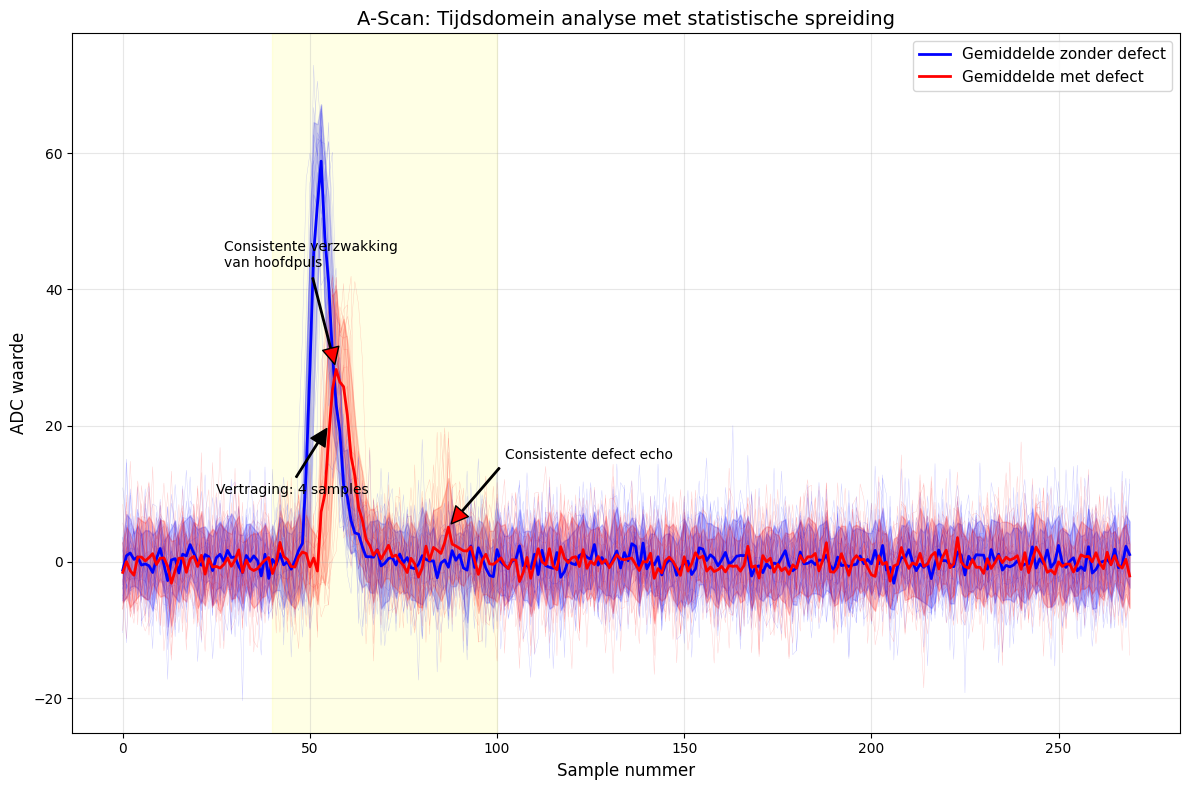

C:\Users\q.koelman\AppData\Local\Temp\ipykernel_30040\4167141024.py:187: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=11)
C:\Users\q.koelman\AppData\Local\Temp\ipykernel_30040\4167141024.py:194: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


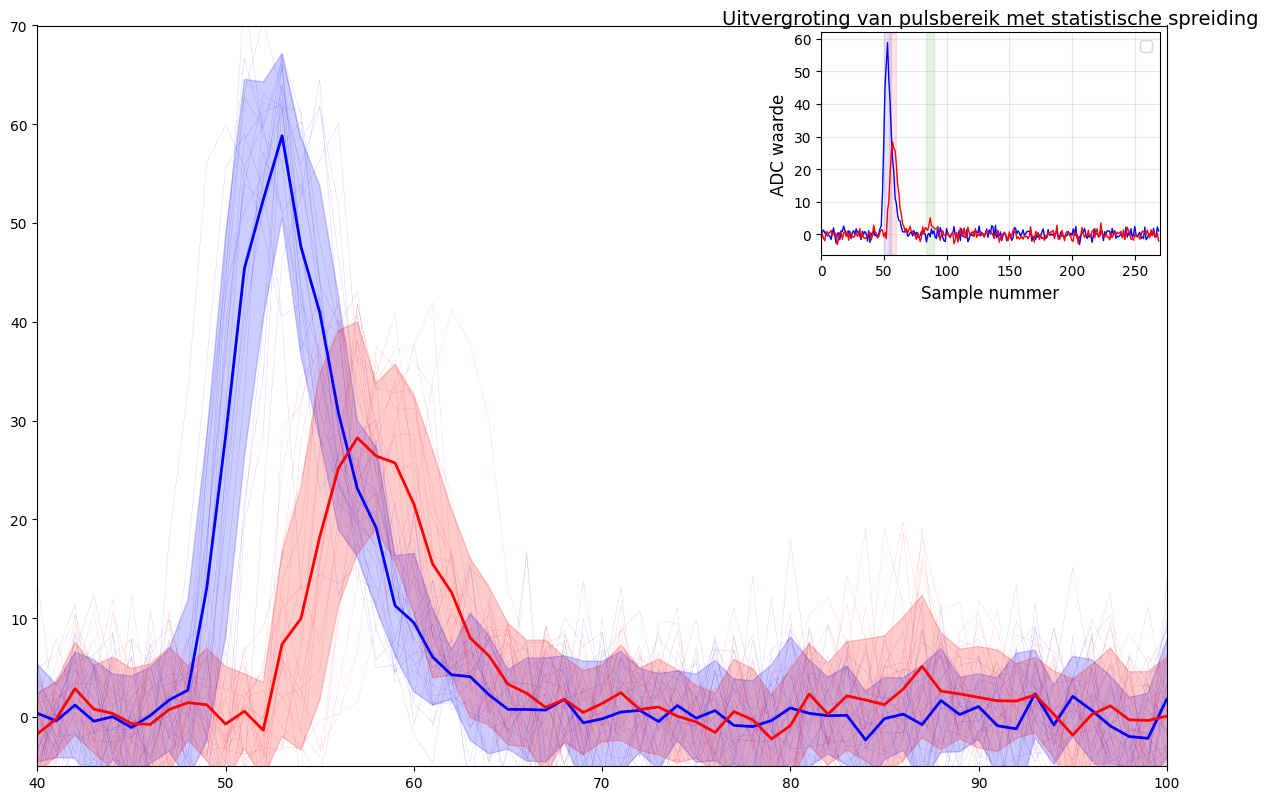

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
np.random.seed(42)  # Voor reproduceerbaarheid

# Parameters voor simulatie
sample_count = 270
base_noise_level = 5
n_measurements = 20  # Aantal metingen voor statistische analyse

# Functie om het ontvangen signaal te simuleren
def create_receiver_signal(samples=sample_count, with_defect=False, noise_var=None):
    # Creëer basisruisniveau, met optionele variatie in ruisniveau
    if noise_var is None:
        noise_var = base_noise_level
    signal_data = np.random.normal(0, noise_var, samples)

    # Parameters voor de ontvangen puls
    if not with_defect:
        pulse_position = int(50 + np.random.normal(0, 1))  # Kleine variatie in aankomsttijd
    else:
        # Met defect is er een grotere vertraging met meer variatie
        pulse_position = int(55 + np.random.normal(0, 1.5))

    # Zorg ervoor dat pulse_position binnen geldige grenzen blijft
    pulse_position = max(0, min(pulse_position, samples - 16))
    pulse_width = 15

    # Pulshoogte zonder defect is sterker
    if not with_defect:
        pulse_height = 60 + np.random.normal(0, 2)
        pulse_decay = 0.3
    else:
        # Met defect is de puls zwakker
        pulse_height = 35 + np.random.normal(0, 2)
        pulse_decay = 0.4

    # Creëer de ontvangen puls
    for i in range(pulse_width):
        pos = min(pulse_position + i, samples - 1)
        if i < 3:
            # Opbouwfase
            signal_data[pos] += pulse_height * (i+1)/3
        elif i < 5:
            # Plateau
            signal_data[pos] += pulse_height
        else:
            # Afname
            signal_data[pos] += pulse_height * np.exp(-pulse_decay * (i-4))

    # Als er een defect is, kunnen we extra reflecties zien
    if with_defect:
        # Extra pulsje door reflectie van defect
        echo_position = int(pulse_position + 30 + np.random.normal(0, 1.5))
        echo_position = max(0, min(echo_position, samples - 9))
        echo_height = 15 + np.random.normal(0, 1)
        echo_width = 8

        for i in range(echo_width):
            pos = min(echo_position + i, samples - 1)
            if i < 2:
                signal_data[pos] += echo_height * i/2
            else:
                signal_data[pos] += echo_height * np.exp(-0.6 * (i-1))

    return signal_data

# Genereer meerdere signalen voor statistische analyse
signals_no_defect = []
signals_with_defect = []

for i in range(n_measurements):
    noise_var = base_noise_level * np.random.uniform(0.9, 1.1)
    signals_no_defect.append(create_receiver_signal(with_defect=False, noise_var=noise_var))
    signals_with_defect.append(create_receiver_signal(with_defect=True, noise_var=noise_var))

# Bereken gemiddelde signalen en standaarddeviaties
mean_signal_no_defect = np.mean(signals_no_defect, axis=0)
std_signal_no_defect = np.std(signals_no_defect, axis=0)

mean_signal_with_defect = np.mean(signals_with_defect, axis=0)
std_signal_with_defect = np.std(signals_with_defect, axis=0)

# Verbeterde tijdsdomein plot met meerdere metingen
plt.figure(figsize=(12, 8))

# Plot alle individuele metingen met lage alpha (transparantie)
for i in range(n_measurements):
    plt.plot(signals_no_defect[i], 'b-', linewidth=0.3, alpha=0.2)
    plt.plot(signals_with_defect[i], 'r-', linewidth=0.3, alpha=0.2)

# Plot de gemiddelde signalen met confidence bands
plt.plot(mean_signal_no_defect, 'b-', linewidth=2, label='Gemiddelde zonder defect')
plt.plot(mean_signal_with_defect, 'r-', linewidth=2, label='Gemiddelde met defect')

# Voeg confidence bands toe (± 1 standaarddeviatie)
plt.fill_between(range(sample_count),
                 mean_signal_no_defect - std_signal_no_defect,
                 mean_signal_no_defect + std_signal_no_defect,
                 color='blue', alpha=0.2)

plt.fill_between(range(sample_count),
                 mean_signal_with_defect - std_signal_with_defect,
                 mean_signal_with_defect + std_signal_with_defect,
                 color='red', alpha=0.2)

# Title and labels
plt.title('A-Scan: Tijdsdomein analyse met statistische spreiding', fontsize=14)
plt.xlabel('Sample nummer', fontsize=12)
plt.ylabel('ADC waarde', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Annotaties toevoegen voor de belangrijkste verschillen
main_peak_no_defect = np.argmax(mean_signal_no_defect[40:70]) + 40
main_peak_with_defect = np.argmax(mean_signal_with_defect[40:70]) + 40
defect_echo_peak = np.argmax(mean_signal_with_defect[75:90]) + 75

plt.annotate('Consistente verzwakking\nvan hoofdpuls',
             xy=(main_peak_with_defect, mean_signal_with_defect[main_peak_with_defect]),
             xytext=(main_peak_with_defect-30, mean_signal_with_defect[main_peak_with_defect]+15),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1),
             fontsize=10)

plt.annotate(f'Vertraging: {main_peak_with_defect - main_peak_no_defect} samples',
             xy=((main_peak_no_defect + main_peak_with_defect)/2, 20),
             xytext=((main_peak_no_defect + main_peak_with_defect)/2 - 30, 10),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1),
             fontsize=10)

plt.annotate('Consistente defect echo',
             xy=(defect_echo_peak, mean_signal_with_defect[defect_echo_peak]),
             xytext=(defect_echo_peak+15, mean_signal_with_defect[defect_echo_peak]+10),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1),
             fontsize=10)

# Highlight gebieden van belang
highlight_start = 40
highlight_end = 100
plt.axvspan(highlight_start, highlight_end, color='yellow', alpha=0.1)

plt.tight_layout()
plt.savefig('improved_time_domain.png', dpi=300)
plt.show()

# Maak ook een inzet met een uitvergroting van het interessante gedeelte
plt.figure(figsize=(12, 8))

# Plot alle individuele metingen met lage alpha (transparantie)
for i in range(n_measurements):
    plt.plot(signals_no_defect[i], 'b-', linewidth=0.3, alpha=0.2)
    plt.plot(signals_with_defect[i], 'r-', linewidth=0.3, alpha=0.2)

# Plot de gemiddelde signalen met confidence bands
plt.plot(mean_signal_no_defect, 'b-', linewidth=2, label='Gemiddelde zonder defect')
plt.plot(mean_signal_with_defect, 'r-', linewidth=2, label='Gemiddelde met defect')

# Voeg confidence bands toe (± 1 standaarddeviatie)
plt.fill_between(range(sample_count),
                 mean_signal_no_defect - std_signal_no_defect,
                 mean_signal_no_defect + std_signal_no_defect,
                 color='blue', alpha=0.2)

plt.fill_between(range(sample_count),
                 mean_signal_with_defect - std_signal_with_defect,
                 mean_signal_with_defect + std_signal_with_defect,
                 color='red', alpha=0.2)

# Zoom in op het interessante gedeelte
plt.xlim(highlight_start, highlight_end)
plt.ylim(-5, 70)

# Inset toevoegen met het volledige signaal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(plt.gca(), width="30%", height="30%", loc='upper right')
axins.plot(mean_signal_no_defect, 'b-', linewidth=1)
axins.plot(mean_signal_with_defect, 'r-', linewidth=1)
axins.set_xlim(0, sample_count)
axins.set_title('Volledig signaal', fontsize=8)
axins.grid(True, alpha=0.3)

# Title and labels
plt.title('Uitvergroting van pulsbereik met statistische spreiding', fontsize=14)
plt.xlabel('Sample nummer', fontsize=12)
plt.ylabel('ADC waarde', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Highlight the main pulse and defect echo regions
plt.axvspan(main_peak_no_defect-3, main_peak_no_defect+3, color='blue', alpha=0.1)
plt.axvspan(main_peak_with_defect-3, main_peak_with_defect+3, color='red', alpha=0.1)
plt.axvspan(defect_echo_peak-3, defect_echo_peak+3, color='green', alpha=0.1)

plt.tight_layout()
plt.savefig('improved_time_domain_zoom.png', dpi=300)
plt.show()

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
from scipy.fft import fft, fftfreq
np.random.seed(42)  # Voor reproduceerbaarheid

# Parameters voor simulatie
sample_count = 270
base_noise_level = 5
n_measurements = 50  # Meer metingen voor betere statistiek

# Transducer parameters
transducer_center_freq = 40e3  # Centerfrequentie: 40 kHz (typisch voor ultrasone transducer)
transducer_bandwidth = 5e3     # Bandbreedte: ±5 kHz rond de centerfrequentie

# Functie om het ontvangen signaal te simuleren
def create_receiver_signal(samples=sample_count, with_defect=False, noise_var=None):
    # Creëer basisruisniveau, met optionele variatie in ruisniveau
    if noise_var is None:
        noise_var = base_noise_level
    signal_data = np.random.normal(0, noise_var, samples)

    # Parameters voor de ontvangen puls
    if not with_defect:
        pulse_position = int(50 + np.random.normal(0, 1))  # Kleine variatie in aankomsttijd

        # Gebruik centerfrequentie voor niet-defect signaal met kleine variatie
        freq = transducer_center_freq + np.random.normal(0, 200)  # 200 Hz variatie
    else:
        # Met defect is er een grotere vertraging met meer variatie
        pulse_position = int(55 + np.random.normal(0, 1.5))

        # Bij defect is er een systematische verschuiving in frequentie
        freq = transducer_center_freq - 1500 + np.random.normal(0, 400)  # Verschuiving van ~1.5 kHz met meer variatie

    # Zorg ervoor dat pulse_position binnen geldige grenzen blijft
    pulse_position = max(0, min(pulse_position, samples - 16))
    pulse_width = 15

    # Sample interval in seconden (1/fs), voor het genereren van de golf
    fs = 1e6  # 1 MHz samplefrequentie
    dt = 1/fs
    time_values = np.arange(samples) * dt

    # Pulshoogte zonder defect is sterker
    if not with_defect:
        pulse_envelope = 60 + np.random.normal(0, 2)  # Amplitude
        pulse_decay = 0.3
    else:
        # Met defect is de puls zwakker
        pulse_envelope = 35 + np.random.normal(0, 2)
        pulse_decay = 0.4

    # Creëer puls met betreffende frequentie - nu expliciet een sinusgolf
    pulse_signal = np.zeros(samples)

    # Bereken het tijdsvenster voor de puls
    start_idx = pulse_position
    end_idx = min(start_idx + pulse_width, samples)

    # Creëer een exponentieel afnemende envelope
    envelope = np.ones(end_idx - start_idx)
    for i in range(len(envelope)):
        if i < 3:
            # Opbouwfase
            envelope[i] = (i+1)/3
        elif i < 5:
            # Plateau
            envelope[i] = 1.0
        else:
            # Afname
            envelope[i] = np.exp(-pulse_decay * (i-4))

    # Genereer de werkelijke sinusgolf met de juiste frequentie
    t_segment = time_values[start_idx:end_idx]
    sin_wave = np.sin(2 * np.pi * freq * t_segment)

    # Vermenigvuldig met envelope en amplitude
    pulse_signal[start_idx:end_idx] = pulse_envelope * envelope * sin_wave

    # Voeg puls toe aan het ruissignaal
    signal_data += pulse_signal

    # Als er een defect is, kunnen we extra reflecties zien
    if with_defect:
        # Extra pulsje door reflectie van defect
        echo_position = int(pulse_position + 30 + np.random.normal(0, 1.5))
        echo_position = max(0, min(echo_position, samples - 9))
        echo_height = 25 + np.random.normal(0, 1)
        echo_width = 8

        # Creëer envelope voor echo
        echo_envelope = np.ones(min(echo_width, samples - echo_position))
        for i in range(len(echo_envelope)):
            if i < 2:
                echo_envelope[i] = i/2
            else:
                echo_envelope[i] = np.exp(-0.6 * (i-1))

        # Frequentie van echo kan iets anders zijn door verstrooiing
        echo_freq = freq * (1 + np.random.normal(0, 0.05))  # ±5% variatie

        # Bereken tijdsegment voor echo
        end_echo_idx = min(echo_position + echo_width, samples)
        t_echo = time_values[echo_position:end_echo_idx]

        # Genereer echo-sinusgolf
        echo_wave = np.sin(2 * np.pi * echo_freq * t_echo)

        # Voeg echo toe aan signaal
        signal_data[echo_position:end_echo_idx] += echo_height * echo_envelope * echo_wave

    return signal_data

# Helper functie voor FFT berekening
def compute_fft(signal_data, fs=1e6):
    n = len(signal_data)
    # Window toepassen om spectral leakage te verminderen
    window = sg.windows.hann(n)
    windowed_signal = signal_data * window

    # Bereken FFT
    yf = fft(windowed_signal)
    xf = fftfreq(n, 1/fs)

    # Neem alleen positieve frequenties en normaliseer
    pos_mask = xf >= 0
    xf = xf[pos_mask]
    yf = 2.0/n * np.abs(yf[pos_mask])

    # Verwijder DC-component (zet eerste element op 0)
    yf[0] = 0

    return xf, yf

# Genereer meerdere signalen voor statistische FFT-analyse
signals_no_defect = []
signals_with_defect = []
ffts_no_defect = []
ffts_with_defect = []

# Samplefrequentie van 1 MHz voor demonstratie
fs = 1e6

# Genereer signalen en bereken FFTs
for i in range(n_measurements):
    noise_var = base_noise_level * np.random.uniform(0.9, 1.1)

    # Genereer signalen
    signal_no_defect = create_receiver_signal(with_defect=False, noise_var=noise_var)
    signal_with_defect = create_receiver_signal(with_defect=True, noise_var=noise_var)

    signals_no_defect.append(signal_no_defect)
    signals_with_defect.append(signal_with_defect)

    # Bereken FFTs
    xf_no_defect, yf_no_defect = compute_fft(signal_no_defect, fs)
    xf_with_defect, yf_with_defect = compute_fft(signal_with_defect, fs)

    ffts_no_defect.append(yf_no_defect)
    ffts_with_defect.append(yf_with_defect)

# Converteer Hz naar kHz voor weergave
xf_khz = xf_no_defect / 1000

# Zorg dat alle FFTs dezelfde lengte hebben voor statistiek
min_length = min([len(fft) for fft in ffts_no_defect + ffts_with_defect])
ffts_no_defect_trimmed = [fft[:min_length] for fft in ffts_no_defect]
ffts_with_defect_trimmed = [fft[:min_length] for fft in ffts_with_defect]

# Bereken gemiddelde FFTs en standaarddeviaties
mean_fft_no_defect = np.mean(ffts_no_defect_trimmed, axis=0)
std_fft_no_defect = np.std(ffts_no_defect_trimmed, axis=0)

mean_fft_with_defect = np.mean(ffts_with_defect_trimmed, axis=0)
std_fft_with_defect = np.std(ffts_with_defect_trimmed, axis=0)

# Bereken het verschilspectrum (met defect - zonder defect)
difference_spectrum = mean_fft_with_defect - mean_fft_no_defect

# Bepaal plot bereik en focus op relevante frequenties
freq_min = 20  # kHz
freq_max = 60  # kHz
rel_range_start = np.argmin(np.abs(xf_khz[:min_length] - freq_min))
rel_range_end = np.argmin(np.abs(xf_khz[:min_length] - freq_max))

# PLOT 1: Gemiddeld frequentiespectrum (voor hoofdtekst PvA)
plt.figure(figsize=(10, 6))

# Plot gemiddelde FFTs met confidence bands
plt.plot(xf_khz[:min_length], mean_fft_no_defect, 'b-', linewidth=2, label='Zonder defect')
plt.plot(xf_khz[:min_length], mean_fft_with_defect, 'r-', linewidth=2, label='Met defect')

# Voeg confidence bands toe (± 1 standaarddeviatie)
plt.fill_between(xf_khz[:min_length],
                 mean_fft_no_defect - std_fft_no_defect,
                 mean_fft_no_defect + std_fft_no_defect,
                 color='blue', alpha=0.2)

plt.fill_between(xf_khz[:min_length],
                 mean_fft_with_defect - std_fft_with_defect,
                 mean_fft_with_defect + std_fft_with_defect,
                 color='red', alpha=0.2)

plt.title('Gemiddeld frequentiespectrum', fontsize=14)
plt.xlabel('Frequentie (kHz)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.xlim(freq_min, freq_max)  # Focus op relevant bereik
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Markeer de transducer centerfrequentie
plt.axvline(transducer_center_freq/1000, color='gray', linestyle='--', linewidth=1,
            label=f'Transducer centerfrequentie (40 kHz)')

# Vind pieken in relevant bereik
main_peak_idx_no_defect = rel_range_start + np.argmax(mean_fft_no_defect[rel_range_start:rel_range_end])
main_peak_idx_with_defect = rel_range_start + np.argmax(mean_fft_with_defect[rel_range_start:rel_range_end])

main_freq_no_defect = xf_khz[main_peak_idx_no_defect]
main_freq_with_defect = xf_khz[main_peak_idx_with_defect]

# Bereken procentuele afname in amplitude bij hoofdpiek
amplitude_decrease = (1 - mean_fft_with_defect[main_peak_idx_with_defect] /
                     mean_fft_no_defect[main_peak_idx_no_defect]) * 100

# Voeg informatie toe over de amplitudeafname
plt.annotate(f'Amplitude afname: {amplitude_decrease:.1f}%',
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1),
             fontsize=10, ha='left', va='top')

plt.tight_layout()
plt.savefig('pva_frequentiespectrum.png', dpi=300)
plt.show()

# PLOT 2: Verschilspectrum (voor hoofdtekst PvA)
plt.figure(figsize=(10, 6))

# Plot het verschilspectrum
plt.plot(xf_khz[:min_length], difference_spectrum, 'g-', linewidth=2)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)

# Kleur de gebieden boven en onder nul
plt.fill_between(xf_khz[:min_length], difference_spectrum, 0,
                 where=(difference_spectrum > 0),
                 color='green', alpha=0.3, label='Toename door defect')
plt.fill_between(xf_khz[:min_length], difference_spectrum, 0,
                 where=(difference_spectrum < 0),
                 color='red', alpha=0.3, label='Afname door defect')

plt.title('Verschilspectrum (Met defect - Zonder defect)', fontsize=14)
plt.xlabel('Frequentie (kHz)', fontsize=12)
plt.ylabel('Amplitudeverschil', fontsize=12)
plt.xlim(freq_min, freq_max)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Markeer de transducer centerfrequentie
plt.axvline(transducer_center_freq/1000, color='gray', linestyle='--', linewidth=1,
            label='Transducer centerfrequentie')

# Vind belangrijke verschillen
max_decrease_idx = rel_range_start + np.argmin(difference_spectrum[rel_range_start:rel_range_end])
max_increase_idx = rel_range_start + np.argmax(difference_spectrum[rel_range_start:rel_range_end])

# Voeg annotaties toe
plt.annotate('Maximale afname',
             xy=(xf_khz[max_decrease_idx], difference_spectrum[max_decrease_idx]),
             xytext=(xf_khz[max_decrease_idx]+5, difference_spectrum[max_decrease_idx]-0.02),
             arrowprops=dict(facecolor='red', shrink=0.05, width=1),
             fontsize=10)

plt.annotate('Maximale toename',
             xy=(xf_khz[max_increase_idx], difference_spectrum[max_increase_idx]),
             xytext=(xf_khz[max_increase_idx]-10, difference_spectrum[max_increase_idx]+0.02),
             arrowprops=dict(facecolor='green', shrink=0.05, width=1),
             fontsize=10)

plt.tight_layout()
plt.savefig('pva_verschilspectrum.png', dpi=300)
plt.show()

SyntaxError: unexpected EOF while parsing (3522672128.py, line 260)

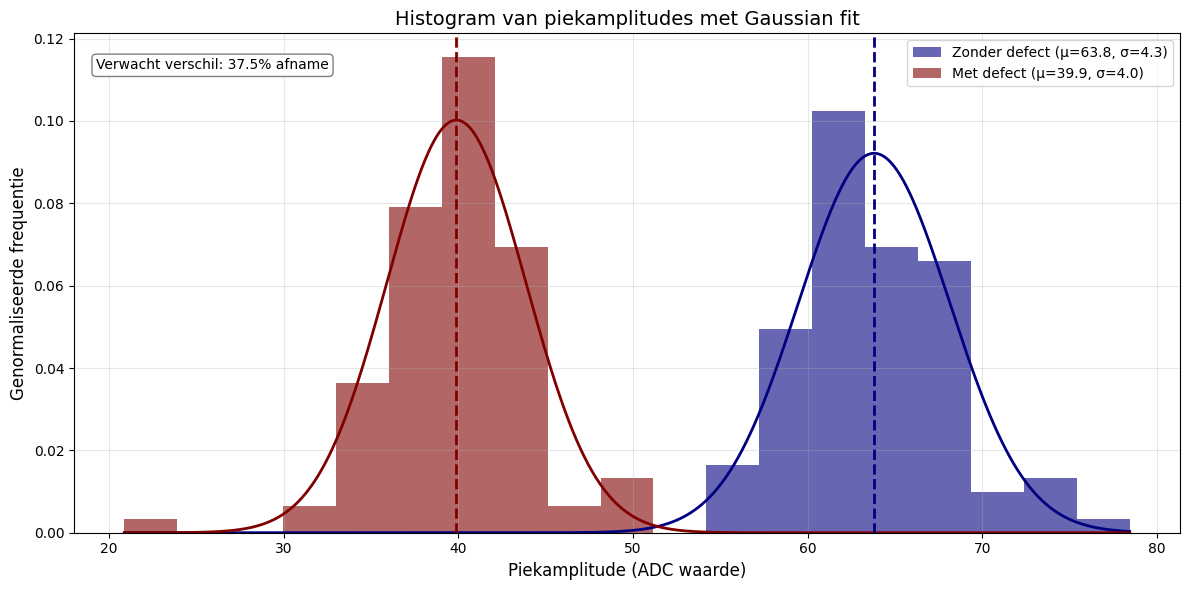

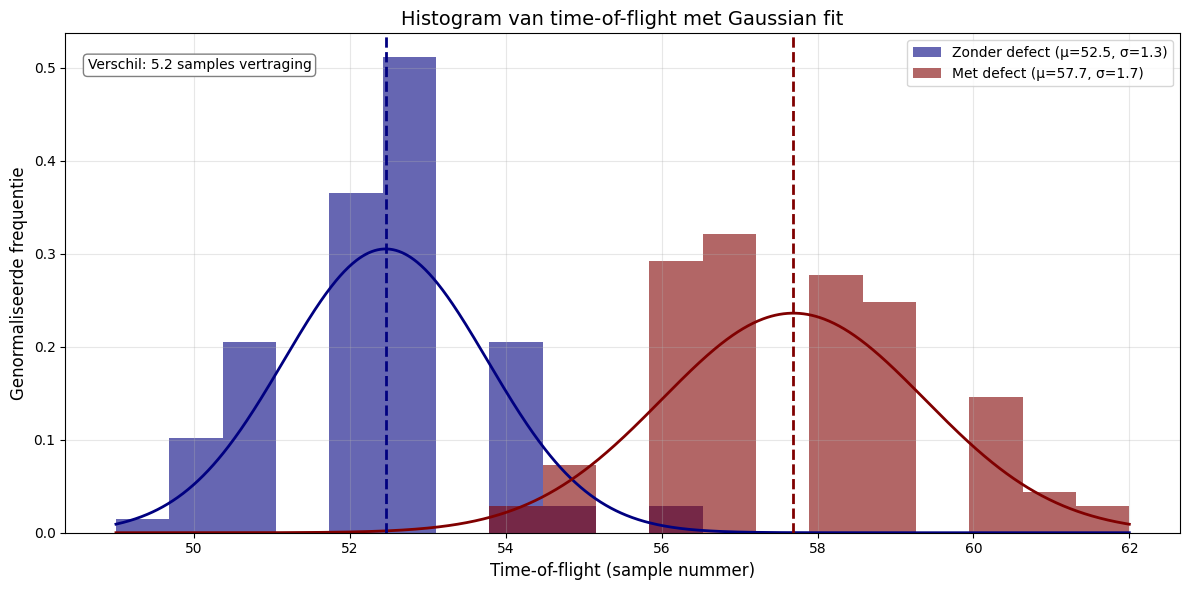

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
from scipy import stats
np.random.seed(42)  # Voor reproduceerbaarheid

# Parameters voor simulatie
sample_count = 270
base_noise_level = 5
n_measurements = 100  # Meer metingen voor betere statistiek

# Functie om het ontvangen signaal te simuleren
def create_receiver_signal(samples=sample_count, with_defect=False, noise_var=None):
    # Creëer basisruisniveau, met optionele variatie in ruisniveau
    if noise_var is None:
        noise_var = base_noise_level
    signal_data = np.random.normal(0, noise_var, samples)

    # Parameters voor de ontvangen puls
    if not with_defect:
        pulse_position = int(50 + np.random.normal(0, 1))  # Kleine variatie in aankomsttijd
    else:
        # Met defect is er een grotere vertraging met meer variatie
        pulse_position = int(55 + np.random.normal(0, 1.5))

    # Zorg ervoor dat pulse_position binnen geldige grenzen blijft
    pulse_position = max(0, min(pulse_position, samples - 16))
    pulse_width = 15

    # Pulshoogte zonder defect is sterker
    if not with_defect:
        pulse_height = 60 + np.random.normal(0, 2)
        pulse_decay = 0.3
    else:
        # Met defect is de puls zwakker
        pulse_height = 35 + np.random.normal(0, 3)
        pulse_decay = 0.4

    # Creëer de ontvangen puls
    for i in range(pulse_width):
        pos = min(pulse_position + i, samples - 1)
        if i < 3:
            # Opbouwfase
            signal_data[pos] += pulse_height * (i+1)/3
        elif i < 5:
            # Plateau
            signal_data[pos] += pulse_height
        else:
            # Afname
            signal_data[pos] += pulse_height * np.exp(-pulse_decay * (i-4))

    # Als er een defect is, kunnen we extra reflecties zien
    if with_defect:
        # Extra pulsje door reflectie van defect
        echo_position = int(pulse_position + 30 + np.random.normal(0, 1.5))
        echo_position = max(0, min(echo_position, samples - 9))
        echo_height = 15 + np.random.normal(0, 1.5)
        echo_width = 8

        for i in range(echo_width):
            pos = min(echo_position + i, samples - 1)
            if i < 2:
                signal_data[pos] += echo_height * i/2
            else:
                signal_data[pos] += echo_height * np.exp(-0.6 * (i-1))

    return signal_data, pulse_position

# Functie om piekamplitude te vinden
def find_peak(signal_data):
    # Focus op een gebied waar we de hoofdpuls verwachten
    search_start = 40
    search_end = min(100, len(signal_data) - 1)
    peak_idx = search_start + np.argmax(signal_data[search_start:search_end])
    peak_value = signal_data[peak_idx]
    return peak_idx, peak_value

# Genereer meerdere signalen voor statistische analyse
peak_amplitudes_no_defect = []
peak_amplitudes_with_defect = []
tof_no_defect = []
tof_with_defect = []
actual_positions_no_defect = []
actual_positions_with_defect = []

for i in range(n_measurements):
    noise_var = base_noise_level * np.random.uniform(0.8, 1.2)

    # Genereer signalen
    signal_no_defect, actual_pos_no_defect = create_receiver_signal(with_defect=False, noise_var=noise_var)
    signal_with_defect, actual_pos_with_defect = create_receiver_signal(with_defect=True, noise_var=noise_var)

    actual_positions_no_defect.append(actual_pos_no_defect)
    actual_positions_with_defect.append(actual_pos_with_defect)

    # Vind pieken
    peak_idx_no_defect, peak_val_no_defect = find_peak(signal_no_defect)
    peak_amplitudes_no_defect.append(peak_val_no_defect)
    tof_no_defect.append(peak_idx_no_defect)

    peak_idx_with_defect, peak_val_with_defect = find_peak(signal_with_defect)
    peak_amplitudes_with_defect.append(peak_val_with_defect)
    tof_with_defect.append(peak_idx_with_defect)

# Bereken gemiddelden en standaarddeviaties
mean_amp_no_defect = np.mean(peak_amplitudes_no_defect)
std_amp_no_defect = np.std(peak_amplitudes_no_defect)
mean_amp_with_defect = np.mean(peak_amplitudes_with_defect)
std_amp_with_defect = np.std(peak_amplitudes_with_defect)

mean_tof_no_defect = np.mean(tof_no_defect)
std_tof_no_defect = np.std(tof_no_defect)
mean_tof_with_defect = np.mean(tof_with_defect)
std_tof_with_defect = np.std(tof_with_defect)

# Bereken ook de procentuele afname in amplitude
amplitude_decrease_percent = (1 - mean_amp_with_defect / mean_amp_no_defect) * 100
tof_increase_samples = mean_tof_with_defect - mean_tof_no_defect

# Donkere kleuren definiëren
dark_blue = '#000080'  # Navy blue
dark_red = '#800000'   # Maroon

# Verbeterd histogram voor piekamplitudes met Gaussian fit
plt.figure(figsize=(12, 6))

# Plot histogrammen
bins = np.linspace(min(min(peak_amplitudes_no_defect), min(peak_amplitudes_with_defect)),
                   max(max(peak_amplitudes_no_defect), max(peak_amplitudes_with_defect)),
                   20)

plt.hist(peak_amplitudes_no_defect, bins=bins, density=True, alpha=0.6, color=dark_blue,
         label=f'Zonder defect (μ={mean_amp_no_defect:.1f}, σ={std_amp_no_defect:.1f})')
plt.hist(peak_amplitudes_with_defect, bins=bins, density=True, alpha=0.6, color=dark_red,
         label=f'Met defect (μ={mean_amp_with_defect:.1f}, σ={std_amp_with_defect:.1f})')

# Voeg Gaussian fits toe
x = np.linspace(bins[0], bins[-1], 1000)
plt.plot(x, stats.norm.pdf(x, mean_amp_no_defect, std_amp_no_defect),
         color=dark_blue, linewidth=2)
plt.plot(x, stats.norm.pdf(x, mean_amp_with_defect, std_amp_with_defect),
         color=dark_red, linewidth=2)

# Voeg verticale lijnen toe voor gemiddelden
plt.axvline(mean_amp_no_defect, color=dark_blue, linestyle='--', linewidth=2)
plt.axvline(mean_amp_with_defect, color=dark_red, linestyle='--', linewidth=2)

# Toevoegen van alleen het verwachte effect zonder statistische significantie
plt.annotate(f'Verwacht verschil: {amplitude_decrease_percent:.1f}% afname',
             xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1),
             fontsize=10, ha='left', va='top')

plt.title('Histogram van piekamplitudes met Gaussian fit', fontsize=14)
plt.xlabel('Piekamplitude (ADC waarde)', fontsize=12)
plt.ylabel('Genormaliseerde frequentie', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.savefig('simplified_amplitude_histogram.png', dpi=300)
plt.show()

# Verbeterd histogram voor time-of-flight met Gaussian fit
plt.figure(figsize=(12, 6))

# Plot histogrammen
bins = np.linspace(min(min(tof_no_defect), min(tof_with_defect)),
                   max(max(tof_no_defect), max(tof_with_defect)),
                   20)

plt.hist(tof_no_defect, bins=bins, density=True, alpha=0.6, color=dark_blue,
         label=f'Zonder defect (μ={mean_tof_no_defect:.1f}, σ={std_tof_no_defect:.1f})')
plt.hist(tof_with_defect, bins=bins, density=True, alpha=0.6, color=dark_red,
         label=f'Met defect (μ={mean_tof_with_defect:.1f}, σ={std_tof_with_defect:.1f})')

# Voeg Gaussian fits toe
x = np.linspace(bins[0], bins[-1], 1000)
plt.plot(x, stats.norm.pdf(x, mean_tof_no_defect, std_tof_no_defect),
         color=dark_blue, linewidth=2)
plt.plot(x, stats.norm.pdf(x, mean_tof_with_defect, std_tof_with_defect),
         color=dark_red, linewidth=2)

# Voeg verticale lijnen toe voor gemiddelden
plt.axvline(mean_tof_no_defect, color=dark_blue, linestyle='--', linewidth=2)
plt.axvline(mean_tof_with_defect, color=dark_red, linestyle='--', linewidth=2)

# Toevoegen van alleen het verwachte effect zonder statistische significantie
plt.annotate(f'Verschil: {tof_increase_samples:.1f} samples vertraging',
             xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1),
             fontsize=10, ha='left', va='top')

plt.title('Histogram van time-of-flight met Gaussian fit', fontsize=14)
plt.xlabel('Time-of-flight (sample nummer)', fontsize=12)
plt.ylabel('Genormaliseerde frequentie', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.savefig('simplified_tof_histogram.png', dpi=300)
plt.show()

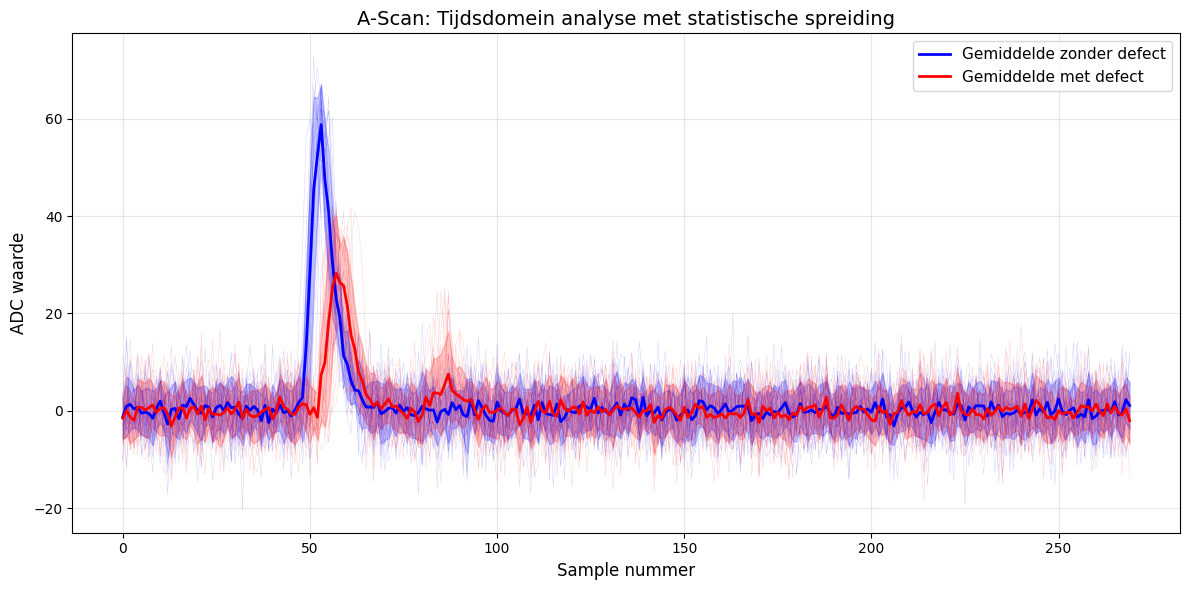

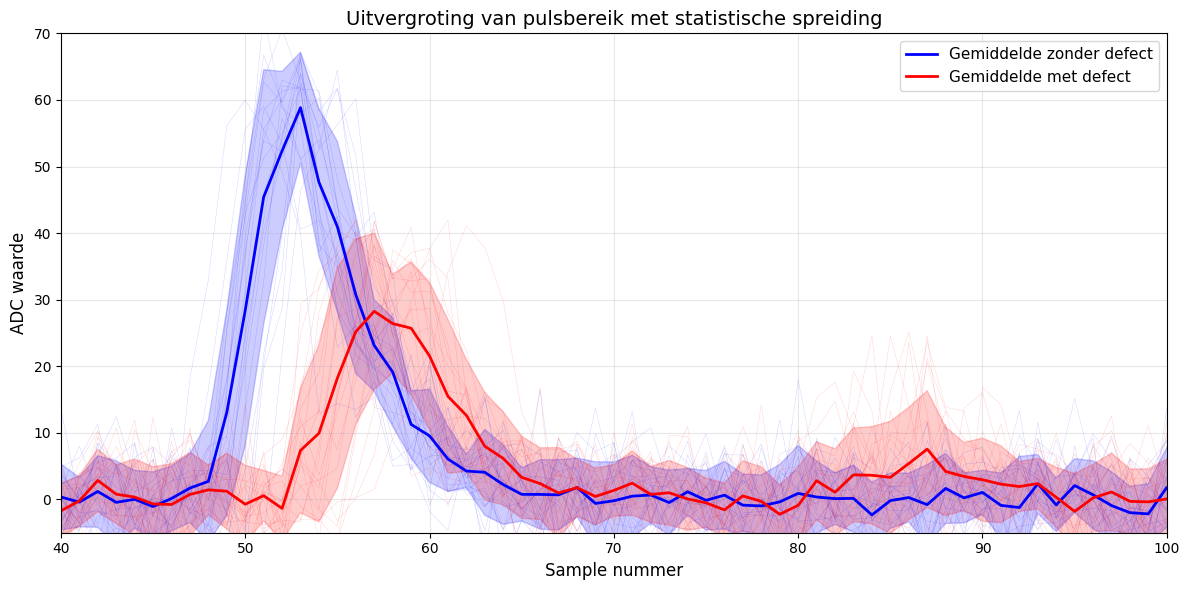

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg
np.random.seed(42)  # Voor reproduceerbaarheid

# Parameters voor simulatie
sample_count = 270
base_noise_level = 5
n_measurements = 20  # Aantal metingen voor statistische analyse

# Gebruik de originele 'reguliere' kleuren
original_blue = 'blue'
original_red = 'red'

# Functie om het ontvangen signaal te simuleren
def create_receiver_signal(samples=sample_count, with_defect=False, noise_var=None):
    # Creëer basisruisniveau, met optionele variatie in ruisniveau
    if noise_var is None:
        noise_var = base_noise_level
    signal_data = np.random.normal(0, noise_var, samples)

    # Parameters voor de ontvangen puls
    if not with_defect:
        pulse_position = int(50 + np.random.normal(0, 1))  # Kleine variatie in aankomsttijd
    else:
        # Met defect is er een grotere vertraging met meer variatie
        pulse_position = int(55 + np.random.normal(0, 1.5))

    # Zorg ervoor dat pulse_position binnen geldige grenzen blijft
    pulse_position = max(0, min(pulse_position, samples - 16))
    pulse_width = 15

    # Pulshoogte zonder defect is sterker
    if not with_defect:
        pulse_height = 60 + np.random.normal(0, 2)
        pulse_decay = 0.3
    else:
        # Met defect is de puls zwakker
        pulse_height = 35 + np.random.normal(0, 2)
        pulse_decay = 0.4

    # Creëer de ontvangen puls
    for i in range(pulse_width):
        pos = min(pulse_position + i, samples - 1)
        if i < 3:
            # Opbouwfase
            signal_data[pos] += pulse_height * (i+1)/3
        elif i < 5:
            # Plateau
            signal_data[pos] += pulse_height
        else:
            # Afname
            signal_data[pos] += pulse_height * np.exp(-pulse_decay * (i-4))

    # Als er een defect is, kunnen we extra reflecties zien
    if with_defect:
        # Extra pulsje door reflectie van defect - VERSTERKT voor betere zichtbaarheid
        echo_position = int(pulse_position + 30 + np.random.normal(0, 1.5))
        echo_position = max(0, min(echo_position, samples - 9))
        echo_height = 25 + np.random.normal(0, 1)  # Verhoogd van 15 naar 25 voor betere zichtbaarheid
        echo_width = 8

        for i in range(echo_width):
            pos = min(echo_position + i, samples - 1)
            if i < 2:
                signal_data[pos] += echo_height * i/2
            else:
                signal_data[pos] += echo_height * np.exp(-0.6 * (i-1))

    return signal_data

# Genereer meerdere signalen voor statistische analyse
signals_no_defect = []
signals_with_defect = []

for i in range(n_measurements):
    noise_var = base_noise_level * np.random.uniform(0.9, 1.1)
    signals_no_defect.append(create_receiver_signal(with_defect=False, noise_var=noise_var))
    signals_with_defect.append(create_receiver_signal(with_defect=True, noise_var=noise_var))

# Bereken gemiddelde signalen en standaarddeviaties
mean_signal_no_defect = np.mean(signals_no_defect, axis=0)
std_signal_no_defect = np.std(signals_no_defect, axis=0)

mean_signal_with_defect = np.mean(signals_with_defect, axis=0)
std_signal_with_defect = np.std(signals_with_defect, axis=0)

# Tijdsdomein plot met meerdere metingen, vereenvoudigd zonder pijlen of achtergrondkleuren
plt.figure(figsize=(12, 6))

# Plot alle individuele metingen met lage alpha (transparantie)
for i in range(n_measurements):
    plt.plot(signals_no_defect[i], color=original_blue, linewidth=0.3, alpha=0.2)
    plt.plot(signals_with_defect[i], color=original_red, linewidth=0.3, alpha=0.2)

# Plot de gemiddelde signalen met confidence bands
plt.plot(mean_signal_no_defect, color=original_blue, linewidth=2, label='Gemiddelde zonder defect')
plt.plot(mean_signal_with_defect, color=original_red, linewidth=2, label='Gemiddelde met defect')

# Voeg confidence bands toe (± 1 standaarddeviatie)
plt.fill_between(range(sample_count),
                 mean_signal_no_defect - std_signal_no_defect,
                 mean_signal_no_defect + std_signal_no_defect,
                 color=original_blue, alpha=0.2)

plt.fill_between(range(sample_count),
                 mean_signal_with_defect - std_signal_with_defect,
                 mean_signal_with_defect + std_signal_with_defect,
                 color=original_red, alpha=0.2)

# Title and labels
plt.title('A-Scan: Tijdsdomein analyse met statistische spreiding', fontsize=14)
plt.xlabel('Sample nummer', fontsize=12)
plt.ylabel('ADC waarde', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

plt.tight_layout()
plt.savefig('original_colors_time_domain.png', dpi=300)
plt.show()

# Ingezoomde versie van de tijdsdomeinanalyse
plt.figure(figsize=(12, 6))

# Plot alle individuele metingen met lage alpha (transparantie)
for i in range(n_measurements):
    plt.plot(signals_no_defect[i], color=original_blue, linewidth=0.3, alpha=0.2)
    plt.plot(signals_with_defect[i], color=original_red, linewidth=0.3, alpha=0.2)

# Plot de gemiddelde signalen met confidence bands
plt.plot(mean_signal_no_defect, color=original_blue, linewidth=2, label='Gemiddelde zonder defect')
plt.plot(mean_signal_with_defect, color=original_red, linewidth=2, label='Gemiddelde met defect')

# Voeg confidence bands toe (± 1 standaarddeviatie)
plt.fill_between(range(sample_count),
                 mean_signal_no_defect - std_signal_no_defect,
                 mean_signal_no_defect + std_signal_no_defect,
                 color=original_blue, alpha=0.2)

plt.fill_between(range(sample_count),
                 mean_signal_with_defect - std_signal_with_defect,
                 mean_signal_with_defect + std_signal_with_defect,
                 color=original_red, alpha=0.2)

# Zoom in op het interessante gedeelte (40-100)
plt.xlim(40, 100)
plt.ylim(-5, 70)

plt.title('Uitvergroting van pulsbereik met statistische spreiding', fontsize=14)
plt.xlabel('Sample nummer', fontsize=12)
plt.ylabel('ADC waarde', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

plt.tight_layout()
plt.savefig('original_colors_zoomed_time_domain.png', dpi=300)
plt.show()